In [97]:
import pandas as pd, numpy as np
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Objective
We have an A/B test data from a mobile game <a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a>, where we are going to analyse players' retention with different treatment of prompt in-app purchases __gates__. As shown below, the __gate__ will show up as players progresses through the levels of the game.
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>
In this experiment, the developer wants to know whether placing the gate at level 40 will boost more players' retention compared to the gate at level 30. Full description and preliminary A/B test analysis can be found on <a href="https://www.datacamp.com/projects/184">Datacamp project page</a>.

However, I am going to explore several other options of assessing A/B test results besides the method of bootstrap sampling that is explained on the Datacamp page.

The result, however, shows that putting the gate at level 40 is ineffective and the retention is lower than the group where the gate shows up at level 30. We will confirm this through other ways that we are going to perform.

## 1. The data
The players are randomly assigned into two groups: `gate_30` and `gate_40` under the column `version` on the dataset. The total players in this dataset is 90,189 with no duplicate `userid`. Also, we have other fields such as:
<ul>
<li><code>sum_gamerounds</code> (the number of game rounds played by the player during the first 14 days after install),
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>

A sneak peek of the data gives us below depiction,

In [2]:
df = pd.read_csv("datasets/cookie_cats.csv")
df.sample(5)

,userid,version,sum_gamerounds,retention_1,retention_7
38670,4283520,gate_40,112,True,True
2502,275887,gate_30,2,False,False
72539,8037409,gate_40,3,False,False
7912,871500,gate_30,2961,True,True
87165,9656426,gate_40,0,False,False


We are more interested in using `retention_7` than `retention_1` column since it is very unlikely to have player hits either level 30 or level 40 after only 1 day installing the game.

However, one important thing to ensure first whether the size of the A/B groups is roughly proportional.

In [3]:
df.groupby(['version']).size()

version
gate_30    44700
gate_40    45489
dtype: int64

And to see whether the difference below is significant?

In [4]:
df.groupby(['version'], as_index=False)['retention_7'].mean()

,version,retention_7
0,gate_30,0.190201
1,gate_40,0.182000


### a. Is the data already sufficient enough?
Before conducting an A/B test it is imperative to determine the minimum sample size in order to ensure minimum detectable effect. Having inadequate samples will likely give uncertain results and we might not be able to detect changes where it is actually there. 

We want to minimize this probability of not admitting a change while there is actually a change, or in other words also called as __false negative__ or __Type-II error__.

However, it is more common to define the converse of it, i.e. __true positive__ or __power__ of the statistical test. We want the probability of accepting the positive change while actually there is indeed a positive change is as high as possible. As we will see, higher sample size will lead to an increase in power.

Referring to <a href="https://books.google.co.id/books/about/Sample_Size_Calculations_in_Clinical_Res.html?id=7_0wDwAAQBAJ&printsec=frontcover&source=kp_read_button&redir_esc=y#v=onepage&q&f=false">this book</a> which dedicated wholly to discuss sample size, the formula to determining the sample size for measuring proportion difference between two groups is

$$n_1=n_2=\frac{(z_{\alpha/2}+z_\beta)^2 (p_1(1-p_1)+p_2(1-p_2))}{\epsilon^2}$$

where 
<li>$z_{\alpha/2}$ is normal quantile value at $\alpha/2$ significance level (usually $\alpha=5\%$),
<li>$z_{\beta}$ is normal quantile value at $\beta$ (usually $\beta=20\%)$ that gives 80% power,
<li>$p_1$ is baseline conversion rate (i.e. 0.190201 in this data),
<li>$\epsilon$ is the minimum detectable effect or effect size which predetermined based on business needs,
<li>$p_2 = p_1 + \epsilon$ is the aimed uplift on the treatment group,</li>

Note that we already have $p_2$ in our data, i.e. 0.182. Before conducting an A/B test, we definitely have no idea what the quantity of $p_2$ is and of course we are not aiming for decrease in retention rate.

Let's try to make a simulation with varying minimum detectable effect; 0.01, 0.02, 0.04, 0.08, 0.16 respectively.

In [92]:
mdes = [.01, .02, .04, .08, .16]
ssize = []
power = 0.8
alpha = 0.05
p1 = df.groupby(['version']).retention_7.mean()[0]

for mde in mdes:
    p2 = p1 + mde
    n = (stats.norm.ppf(1-alpha/2) + stats.norm.ppf(power))**2 * (p1 * (1-p1) + p2 * (1-p2)) / mde**2
    ssize.append(round(n, 5))

print(ssize)

[24656.90692, 6279.91869, 1624.88232, 430.72858, 116.99281]


As you may notice as the minimum detectable effect getting smaller, more sample size is needed in order the test to be able to detect the possible effects. Since the sample in our data is around 40 thousand for each group, it seems the statistical power is already high enough to avoid Type-II error given the simulation above.

## 2. Comparing Two Proportions (Hypothesis test, p-value, and confidence interval)
### a. Hypothesis test
This is a classical-way (frequentist) of comparing proportions between two groups. Firstly, we test the null hypothesis where

$$H_0: p_1 - p_2 = 0$$

with test statistic that asymptotically follows standard normal distribution as

$$\begin{aligned}
Z &= \frac{(\hat{p}_1-\hat{p}_2) - (p_1-p_2)}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1}+\frac{1}{n_2}\right)}} \\
\end{aligned}$$

where the pooled proportion is

$$\hat{p} = \frac{Y_1+Y_2}{n_1+n_2}$$


The test statistic $Z$ consists of numerator $\hat{p}_1-\hat{p}_2$ (`gate_30` group $-$ `gate_40` group) which is our point estimate and $p_1-p_2$ as the value we want to compare with (i.e. zero). The denominator is basically the estimated standard deviation of retention difference, namely $\text{SD}(p_1-p_2)$ or $\sqrt{\text{Var}(p_1-p_2)}$. I would recommend to look onto <a href="https://newonlinecourses.science.psu.edu/stat414/node/268/">this explanation</a> for a brief derivation of the formula. Computing the values, 

In [5]:
df_grp = df.groupby(['version'])
p1_hat = df_grp.retention_7.mean()[0]
p2_hat = df_grp.retention_7.mean()[1]
n1 = df_grp.retention_7.size()[0]
n2 = df_grp.retention_7.size()[1]
Y1 = df_grp.retention_7.sum()[0]
Y2 = df_grp.retention_7.sum()[1]

phat = (Y1+Y2)/(n1+n2)
Z = (p1_hat - p2_hat) / np.sqrt(phat * (1-phat) * (1/n1 + 1/n2))
print(round(Z, 3))

3.164


we obtain $Z=3.164$ and as you may remember this value is within the rejection region at 5% significance level (where the threshold is $\pm{1.96}$). Therefore __we reject the null and conclude that players on group `gate_30` has significantly different (i.e. higher) retention rate than players on group `gate_40`__. Sadly, moving the gate to level 40 turns out to lower the retention rate of the players.

### b. P-value approach
Either way, we could find the p-value of this result. Finding the probability of the tails on both side with $Z=\pm{3.164}$, we obtain

In [6]:
2 * (1 - stats.norm.cdf(Z))

0.0015542499756142636

which is reasonably small (p-value $< 0.05$) and the conclusion still holds the same. 

If you are lazy enough and not knowing the formula, we can however utilize one of the scipy stats methods which returns the exact same quantile and p-value. But first we need to input the values in either 0/1 form.

In [101]:
grp_A = df[df.version=='gate_30'].retention_7.replace({True: 1, False: 0})
grp_B = df[df.version=='gate_40'].retention_7.replace({True: 1, False: 0})
stats.ttest_ind(grp_A, grp_B)

Ttest_indResult(statistic=3.1644994996802778, pvalue=0.0015540151201088365)

### c. Confidence interval
Lastly, we could alternatively find the confidence interval of the retention difference. If the confidence interval happens to contain zero, then it is likely that the difference is not statistically significant and we cannot safely conclude the retention is different between the groups. Remember that the confidence interval formula goes like this

$$\text{point estimate} \ \pm \ \text{critical value} \ \times \sqrt{\text{Var(point estimate)}}$$

and for our case it is

$$(\hat{p}_1-\hat{p}_2) \ \pm z_{\alpha/2} \ \times \sqrt{\frac{\hat{p}_1(1-\hat{p}_1)}{n_1} + \frac{\hat{p}_2(1-\hat{p}_2)}{n_2}}$$

For this case, we have a slightly difference variance of the point estimate than we had earlier. For the reason why, refer to <a href="https://newonlinecourses.science.psu.edu/stat414/node/209/"> this link</a> for the explanation. Then we obtain the confidence interval within

In [7]:
marg_err = stats.norm.ppf(0.975) * np.sqrt((p1_hat * (1-p1_hat) / n1) + (p2_hat * (1- p2_hat) / n2))
low_bnd = (p1_hat - p2_hat) - marg_err
upp_bnd = (p1_hat - p2_hat) + marg_err
conf_int = (round(low_bnd, 5), round(upp_bnd, 5))
print(conf_int)

(0.00312, 0.01328)


The confidence interval suggests the retention difference is indeed statistically significant.

## 2. Bayesian analysis
Another useful method to analyse the A/B test result is using Bayesian framework. It offers a more interpretable question to business stakeholders such as __"what is the probability putting the gate at level 40 gives more retention than putting the gates at level 30?"__ instead of frequentist approach that states mere statistical significance (also there has been a long-standing debate surrounding the use of p-value).

In Bayesian inference, typically we have the following formula:

$$p(\theta | y) \propto p(\theta) \ \times \ p(y | \theta)$$

where it means our belief regarding a parameter (i.e. $\theta$ is retention rate in this case) given the observed data is proportional with our __prior__ belief about the parameter multiplied by the __likelihood__ of the observation that we believe stems from the given parameter. The LHS part of the equation often called as __posterior__. We need to determine the statistical distribution of these three components.

In the end, we then sample the posterior distribution by doing Monte Carlo simulation and analyse the results from the generated samples.

### a. Likelihood function
Now, you might notice that the retention rate on each group is a series of Bernoulli trials (come back 7 days after installation or not) i.e. __distributed binomially__ (actually this plays part as well in the derivation on the frequentist part earlier). These series of Bernoulli trials is our __likelihood distributions__ or we denote that as 

$$y|\theta \sim \text{Binomial}(n, \theta)$$ 

with $n$ trials and $y$ successes (showing up) with probability $\theta$.

### b. Prior distribution
What about the __prior distribution__, the prior belief about the retention rate? One thing for sure is that the retention rate is a value within [0, 1] and a __beta distribution__ seems to have this range of value so we decide to choose this distribution as our prior. 

However, we can actually use any kind of prior besides beta distribution that has support between 0 and 1 (such as gamma distribution), but there is a nice thing about beta distribution with binomial distribution. They have a __conjugacy__ property that allows for mathematical convenience; i.e. the posterior distribution will be also of the form of prior distribution but with updated parameters. 

### c. Posterior distribution
Now, consider $\theta \sim \text{Beta}(a, b)$, then the preceding formula becomes

$$\begin{aligned}
p(\theta | y) &\propto \theta^{a-1}(1-\theta)^{b-1} \ \times \theta^{y}(1-\theta)^{n-y} \\
&\propto \theta^{a+y-1}(1-\theta)^{b+n-y-1} \\
\end{aligned}$$

Then our posterior distribution is also a beta distribution with the following parameter

$$\theta | y \sim \text{Beta}(a+y, b+n-y)$$

here I omitted $\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}$ and ${n \choose y}$ term on both the beta and binomial density above since they give no contribution to the parameter $\theta$. The posterior distribution above can also be rephrased as

$$\theta | y \sim \text{Beta}(a+\text{successes}, b+\text{failures})$$

The next __important__ step is we compute the posterior distribution of each control and treatment group and simulate the samples out of it using Monte Carlo procedures as many as possible. We then compare the Monte Carlo samples between the two groups.

For now, we set the prior as $\theta \sim \text{Beta}(1, 1)$ which is also called __non-informative prior__, since it gives basically no information/emphasize towards particular value of the parameter that we want to measure. We will discuss how to choose prior on next post.

The probability having more retention by moving the gate to level 40 is then

In [8]:
a, b = 1, 1
nsize = 10**6
posterior_gate_30 = np.random.beta(a + Y1, b + n1 - Y1, size=nsize)
posterior_gate_40 = np.random.beta(a + Y2, b + n2 - Y2, size=nsize)

prob = np.mean(posterior_gate_40 > posterior_gate_30)
print("{:.3f}%".format(prob*100))

0.083%


so it is unwise to move the gate to level 40 as the probability is very small.

### d. Intro to PyMC3: probabilistic programming library
PyMC3 is a versatile library to perform Bayesian inference. It has many advanced sampling methods, even the default sampler is the <a href="http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/">No U-Turn Sampling (NUTS)</a> algorithm, one of the recent variant of Monte Carlo method that handles intractable posterior distribution; posterior that cannot be solved analytically because of not using conjugate prior in the model specification.

It might be an overkill to use PyMC3 in this problem since the posterior already has a nice beta distribution form, but this part serves as a useful warm-up before we further discuss Bayesian inference in the next blog post.

In [9]:
import pymc3 as pm

gate30 = np.array(df[df.version=='gate_30']['retention_7'].replace({False: 0, True: 1}))
gate40 = np.array(df[df.version=='gate_40']['retention_7'].replace({False: 0, True: 1}))

with pm.Model() as model:
    # Priors
    gate30_prior = pm.Beta('theta30', alpha=a, beta=b)
    gate40_prior = pm.Beta('theta40', alpha=a, beta=b)
    
    # Likelihood
    gate30_ylike = pm.Bernoulli('y30', p=gate30_prior, observed=gate30)
    gate40_ylike = pm.Bernoulli('y40', p=gate40_prior, observed=gate40)
    
    # Difference
    retention_diff = pm.Deterministic('diff', gate40_prior-gate30_prior)
    
    # The inference button
    trace = pm.sample(5000)

/Users/dims/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta40, theta30]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:55<00:00, 198.22draws/s]


The probability of getting higher retention rate by putting the gate at level 40 is

In [10]:
np.mean(trace['theta40'] > trace['theta30'])

0.001

One nice thing with PyMC3 it can give us the following sample distribution.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x123b0ddd8>],
      dtype=object)

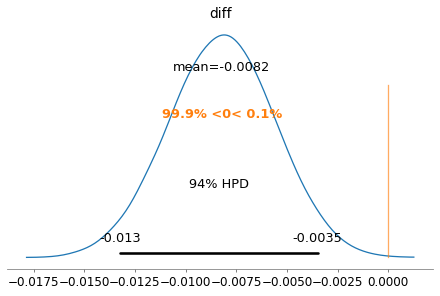

In [11]:
pm.plot_posterior(trace, var_names=['diff'], ref_val=0, textsize=12, figsize=(6,4))

The figure tells us that the probability of moving the gate to level 40 gives more retention is 0%, which also means 100% of the time putting the gate as it was is more effective than at the gate level 40. 

The HPD stands for __highest posterior density__ that in this case shows us by moving the gate at level 40, 94% of the time the retention rate difference will be between -1.3% and -0.34%, which also actually worse no matter we repeat the experiment!

## 3. Generalized Linear Model
I was thinking that given the data we have below

In [12]:
df.sample(5)

,userid,version,sum_gamerounds,retention_1,retention_7
26716,2976967,gate_40,21,True,False
17502,1949342,gate_30,5,False,False
8023,885695,gate_40,16,False,False
54036,5998556,gate_40,73,True,True
56832,6298836,gate_30,3,False,False


we can actually fit a linear model by treating `retention_7` as independent variable and the rest as dependent variables (except `userid`). Given this situation, we can fit a probit or logit model. It is actually quite common, especially in econometrics, to employ this method to compare changes between groups. Later, we will see whether the fitted coefficient of `version` is statistically significant and has positive value.

Firstly, we one-hot encode these categorical covariates.

In [14]:
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

le = LabelEncoder()
categorical = ['version', 'retention_1', 'retention_7']
df_prepro = df.copy()

for col in categorical:
    df_prepro[col] = le.fit_transform(df_prepro[col])
df_prepro.sample(5)

y = df_prepro['retention_7']
X = df_prepro.drop(['retention_7','userid'], axis=1)
X = sm.add_constant(X)

### a. Probit model
Probit model is one of the generalised linear model where the response variable is binary and the estimated coefficient is found through maximum-likelihood estimation procedure. It has __probit link function__ that "connects" the linear combination of dependent variables which expressed as

$$p(y=1|X) = \Phi\left(\beta^T X\right)$$

where notation $\Phi$ denotes the standard normal distribution. Following we utilize the statsmodels library to fit the model.

In [15]:
probit_mod = sm.Probit(y, X)
probit_res = probit_mod.fit()

print(probit_res.summary())

Optimization terminated successfully.
         Current function value: 0.329974
         Iterations 10
                          Probit Regression Results                           
Dep. Variable:            retention_7   No. Observations:                90189
Model:                         Probit   Df Residuals:                    90185
Method:                           MLE   Df Model:                            3
Date:                Mon, 30 Dec 2019   Pseudo R-squ.:                  0.3132
Time:                        17:22:35   Log-Likelihood:                -29760.
converged:                       True   LL-Null:                       -43333.
                                        LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.6915      0.011   -155.157      0.000      -1.713      -1.670
version         

The fitted coefficient value for `version` is $\beta_1=-0.0376$. This negative sign indicates that a change of gate placement to level 40, will decrease the probability a player to show up after 7 days installing the game (since we have mapped 0 as `gate_30` and 1 as `gate_40`).

Also, Wald's hypothesis test can be performed to test whether the fitted coefficient on `version` is significantly different from zero. Wald's principle states that the following statistic asymptotically goes to standard normal distribution

$$\frac{\hat{\beta}-\beta_0}{\hat{\text{SE}}(\hat{\beta})} \sim \text{N}(0,1)$$

we test the coefficient and the p-value it has is

In [16]:
2 * stats.norm.cdf(probit_res.params[1], loc=0, scale=probit_res.bse[1])

0.0010383866526273908

Altogether, we can safely assume the effect of moving the gate to level 40 will decrease the retention rate and it is statistically significant since the Wald's statistic is considerably small (less than 5% significant level).

### b. Logit model
Similar to probit model, logit model or logistic regression model gives output that only takes two values. The linear combination of covariates is "connected" through a __logit link function__ as follows

$$\text{log}\frac{p(y=1|X)}{1-p(y=1|X)} = \beta^TX$$

In [17]:
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.327800
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            retention_7   No. Observations:                90189
Model:                          Logit   Df Residuals:                    90185
Method:                           MLE   Df Model:                            3
Date:                Mon, 30 Dec 2019   Pseudo R-squ.:                  0.3177
Time:                        17:23:50   Log-Likelihood:                -29564.
converged:                       True   LL-Null:                       -43333.
                                        LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.9677      0.022   -136.456      0.000      -3.010      -2.925
version          

The fitted coefficient of `version` is again has negative sign and significant. The conclusion holds the same, although this model estimates more decrease in retention rate $(\beta_1 = -0.0792)$ compared to the probit model earlier.

### c. Additional analysis
Interestingly, both `sum_gamerounds` and `retention_1` are also significant and has positive sign. This can be thought as 
<ul>
<li> The more people spend their time playing the game the more likely they are going to login the game again after 7 days (although this variable measures the playing time for the first 14-day),</li>
<li> Having a player comes back the day after installing the game also increases the probability to show up a week later.
</ul>